In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ayuraj_asl_dataset_path = kagglehub.dataset_download('ayuraj/asl-dataset')
print('Data source import complete.')

c:\Users\pokem\OneDrive\Área de Trabalho\AtividadesDELL\ExercicioIntegrador4\ml-cnn-signLanguageClassification\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 56.9M/56.9M [00:10<00:00, 5.75MB/s]

Extracting files...


Data source import complete.


<div class="alert alert-block alert-info"><h1 style="text-align:center;color:black"> Sign Language Classification 📷 🚀 </h1> </div>

Speech impaired people use hand signs and gestures to communicate. Normal people face difficulty in understanding their language. Hence there is a need of a system which recognizes the different signs, gestures and conveys the information to the normal people.

The dataset can be used for learning how to develop,evaluate and use convolutional deep learning neural networks for classification of images.

This is the Example of Multiclass classification problem.

This includes how to develop a robust test harness for estimating the performance of the model, exploring improvements for the model by changing the paramters of the model, saving and loading the model to make predicitions on new data.


![hand signs.png](attachment:ea1e8cbd-da73-4773-b9c8-e9bc22cb7a8a.png)

<div class="alert alert-block alert-warning"><h2 style="text-align:Center;color:black">Table of Content </h2> </div>

1. [Introduction 💥](#1)
1. [Data Description](#2)
1. [Loading Libraries📖](#3)
1. [Data Extraction📁](#4)
1. [Data Exploration📊](#5)
1. [Train Test Split](#6)
1. [Data Preparation 🛠️](#7)
    1. [Image Data Generator](#8)
        1. [Flow from directory](#9)
1. [Deep learning Model ⚙️](#10)
    1. [Model Layers](#11)
    1. [Callbacks](#12)
    1. [Compile Model](#13)
    1. [Fit Model](#14)
    1. [Evaluvation](#15)
    1. [Plot Result](#16)
1. [Prediction](#17)
1. [Conclusion](#18)

<a id='1'></a>
<div class="alert alert-block alert-danger"><h2 style="text-align:center;color:black"> Introduction 💥</h2> </div>

In this article, we will discover how to develop a CNN to classify images of American sign langauage.

After reading this article, you will know :

* How to load and prepare the images for training purpose.
* How to split data for training and validation purpose.
* There is no need to apply Data Augmentation to the data.
* How to develop a CNN model using keras and how to choose various parameters for improving performance of the model.
* How to evaluate performance of our model.
* How to save and load a model for further predictions.
* How to draw the confusion matrix for trained model.

<a id='2'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Description </h2> </div>

The data set is a collection of images of alphabets from the American Sign Language, separated in 10 folders which represent the various classes.

The data set contains 700 images which are 400x400 pixels. There are 10 classes.

The 10 classes contain 0-9.

<a id='3'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Loading Libraries </h2> </div>

In [4]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import splitfolders

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.metrics import classification_report, confusion_matrix

KeyboardInterrupt: 

<a id='4'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Extraction </h2> </div>
In this part we are going to extract an image of each class we have.

In [ ]:
import os
import pandas as pd
import re

base_path = "/kaggle/input/asl-dataset/asl_dataset/"
filtered_path = "/kaggle/working/filtered_data/"
os.makedirs(filtered_path, exist_ok=True)

categories = {i: str(i) for i in range(10)}

print(f"Criando diretório filtrado em: {filtered_path}")

for folder_name in categories.values():
    src_folder = os.path.join(base_path, folder_name)
    dst_folder = os.path.join(filtered_path, folder_name)
    if os.path.isdir(src_folder) and not os.path.exists(dst_folder):
        os.symlink(src_folder, dst_folder)

filenames_list = []
categories_list = []

for category, folder_name in categories.items():
    folder_path = os.path.join(filtered_path, folder_name)
    if os.path.isdir(folder_path):
        filenames = os.listdir(folder_path)
        filenames_list += filenames
        categories_list += [category] * len(filenames)

df = pd.DataFrame({
    "filename": filenames_list,
    "category": categories_list
})

df["filepath"] = df.apply(lambda x: f"{x['category']}/{x['filename']}", axis=1)

df = df.sample(frac=1).reset_index(drop=True)


In [ ]:
df

filename  category
0      t/hand2_t_left_seg_1_cropped.jpeg        29
1     7/hand1_7_right_seg_3_cropped.jpeg         7
2       d/hand1_d_bot_seg_5_cropped.jpeg        13
3       a/hand1_a_bot_seg_5_cropped.jpeg        10
4       0/hand5_0_dif_seg_2_cropped.jpeg         0
...                                  ...       ...
2510  c/hand1_c_right_seg_5_cropped.jpeg        12
2511    m/hand5_m_bot_seg_3_cropped.jpeg        22
2512    x/hand5_x_bot_seg_4_cropped.jpeg        33
2513    a/hand2_a_dif_seg_5_cropped.jpeg        10
2514   k/hand1_k_left_seg_2_cropped.jpeg        20

[2515 rows x 2 columns]

In [ ]:
print("number of elements = ", len(df))

number of elements =  2515


<a id='5'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Exploration </h2> </div>

First, we start by visualizing the variable of interest.

Let's view more images in a grid format.

<h5 style="text-align:center;color:Green">We visualize few images of ASL. </h5>

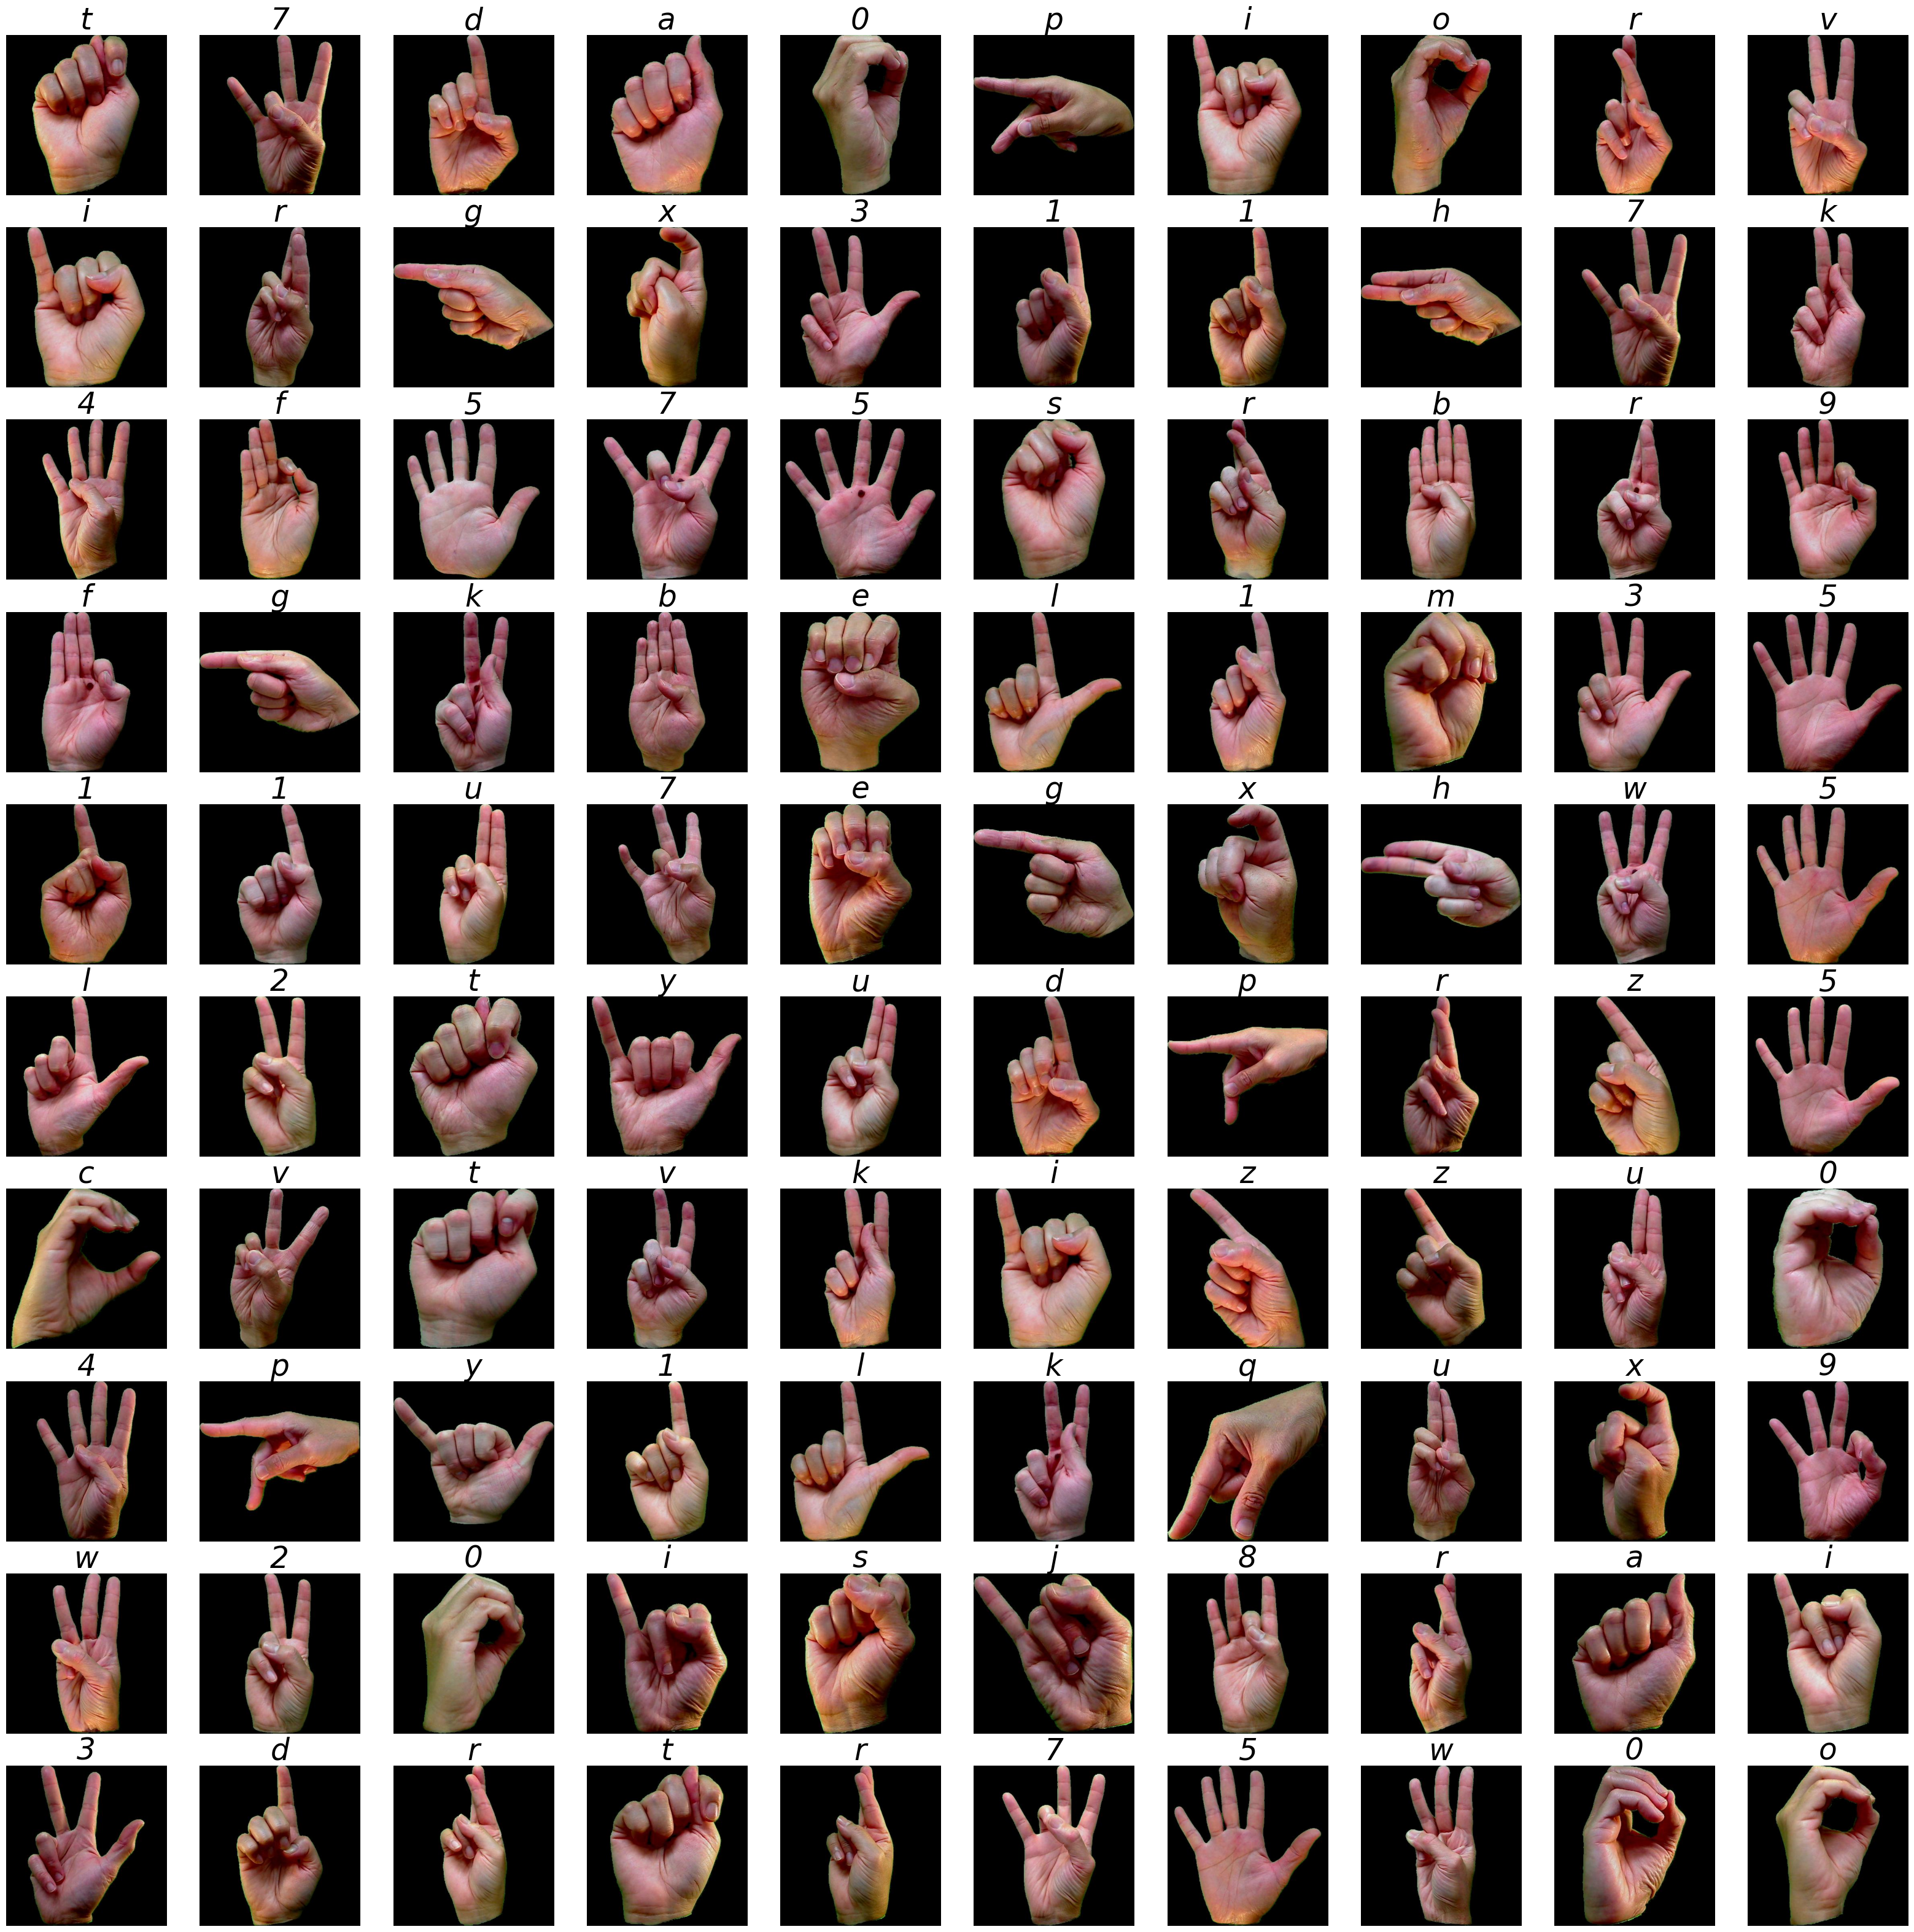

In [ ]:
plt.figure(figsize=(40, 40))

for i in range(100):
    path = os.path.join(base_path, df.filepath[i])
    img = plt.imread(path)
    plt.subplot(10, 10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]], fontsize=35, fontstyle='italic')
    plt.axis("off")

Now, we will see the distrubution of data in every class.

/tmp/ipython-input-842432032.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)


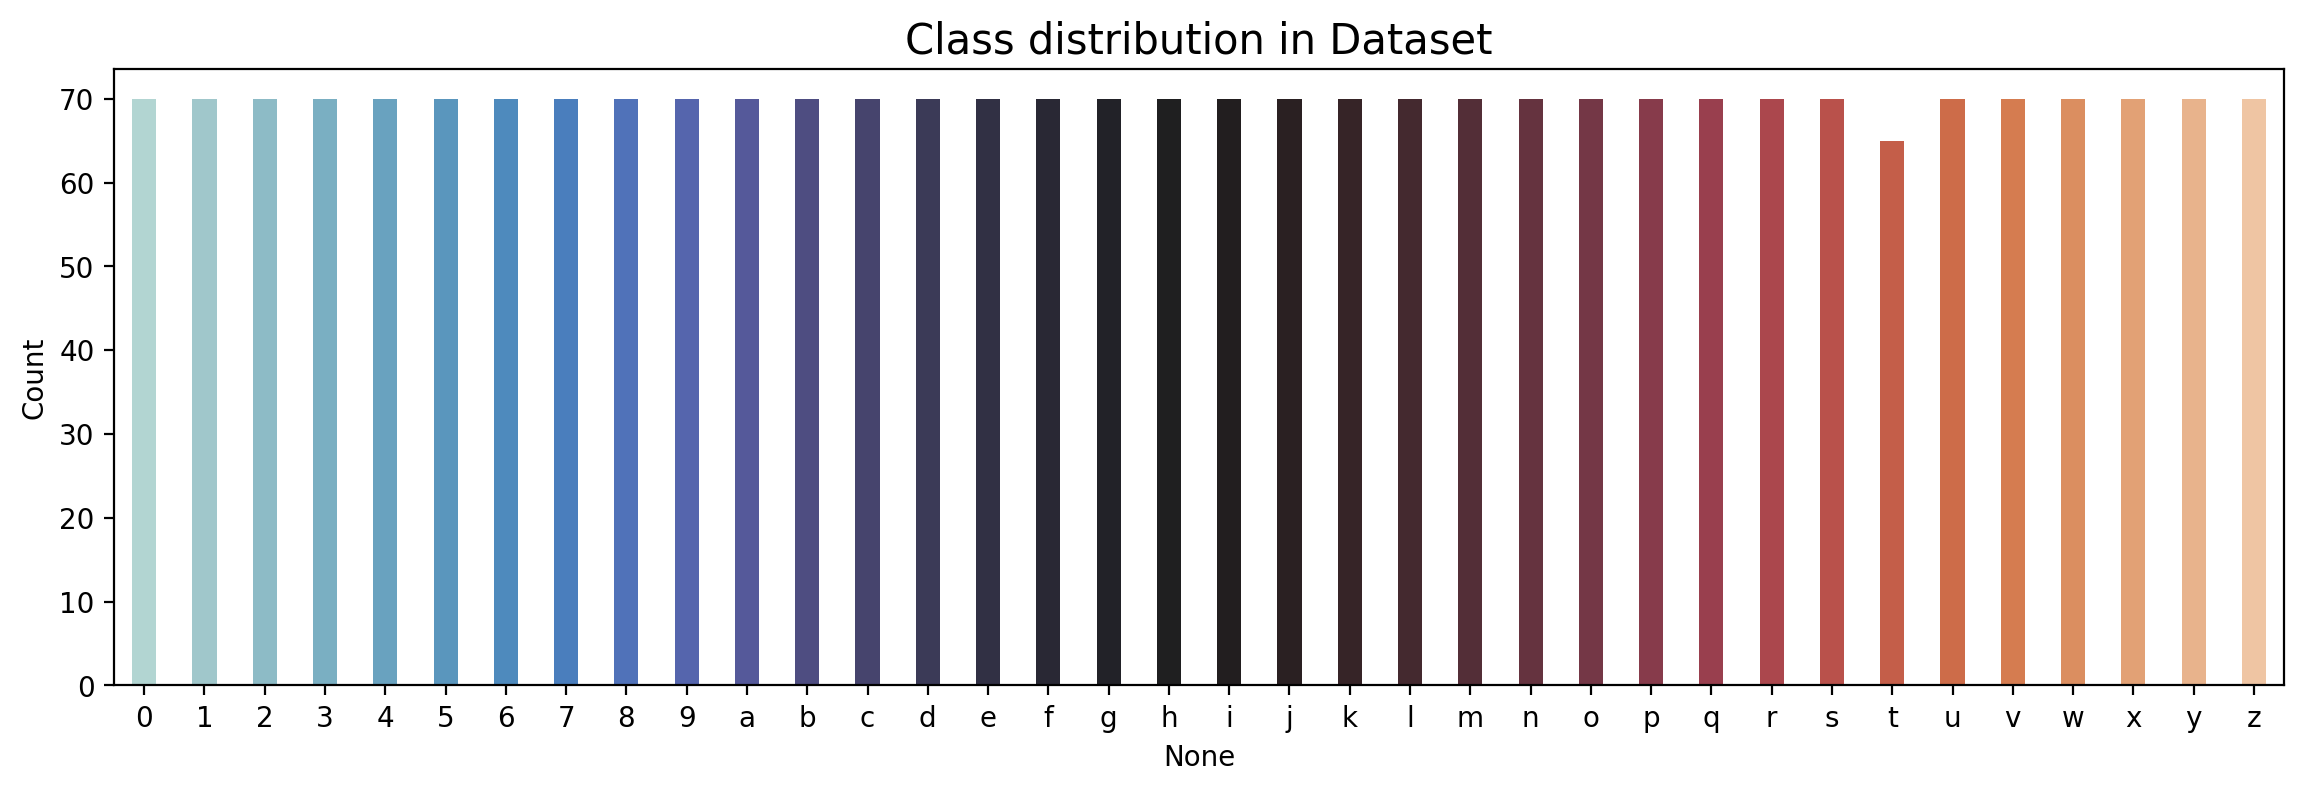

In [ ]:
label,count = np.unique(df.category,return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
plt.show()

<a id='6'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Train Test Split </h2> </div>

We will split the data in three parts.
* Training dataset (70%)
* Validation dataset (15%)
* Testing dataset (15%)

In [ ]:
splitfolders.ratio(filtered_path,output='/kaggle/working/', seed=1333, ratio=(0.7,0.15,0.15))

Copying files: 2515 files [00:10, 231.06 files/s]


We have got an extra class with the name asl_dataset which is the main directory so we are going to remove it using the shutil library

In [ ]:
import shutil
paths = [
    "/kaggle/working/train/asl_dataset",
    "/kaggle/working/val/asl_dataset",
    "/kaggle/working/test/asl_dataset",
]

for path in paths:
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"Removido: {path}")
    else:
        print(f"Diretório não encontrado, ignorado: {path}")

<a id='7'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Preparation </h2> </div>

<a id='8'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black">Image Data Generator </h3> </div>

* The data for will used by flow_from_directory.
* The batch size is 32 and the image size is (150,150).
* The Image Data Generator will be used to rescale the images.

Finally, we will list out all the important parameters and respective values.

In [ ]:
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

batch = 32
image_size = 150
img_channel = 3
n_classes = 10

<a id='9'></a>
<div class="alert alert-block alert-warning"><h4 style="text-align:center;color:black"> Flow from Directory </h4> </div>

* We will import the data from directory.
* we will set **shuffle = False** for test data.

In [ ]:
train_data = image_dataset_from_directory(directory= train_path,
                                         image_size=(image_size,image_size),
                                         batch_size = batch,
                                         label_mode='categorical').map(lambda x, y: (x / 255.0, y))

val_data = image_dataset_from_directory(directory= val_path,
                                       image_size=(image_size,image_size),
                                       batch_size = batch,
                                       label_mode='categorical',
                                       ).map(lambda x, y: (x / 255.0, y))

test_data = image_dataset_from_directory(directory= test_path,
                                         image_size=(image_size,image_size),
                                         batch_size = batch,
                                         label_mode='categorical',
                                         shuffle= False).map(lambda x, y: (x / 255.0, y))

Found 2012 files belonging to 36 classes.
Found 251 files belonging to 36 classes.
Found 252 files belonging to 36 classes.


<a id='10'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Deep Learning Model </h2> </div>


<a id='11'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black">Model Layers </h3> </div>


### Architecture

The architecture of the American Sign Langauge Image Classification model consists of the following Layers and components:

#### Layers :
* The input layer consist of a Conv2D with 32 filters and activation relu.
* The model contain the 2 blocks of convolution with increasing filters and activation relu.
* Each convolution block contains Max pooling (pool_size = 2) and Dropout (0.25).
* The fully connected layers contain Flatten layer, Dense layer with 512 units and a Dropout layer.
* The output layer is a Dense layer with 10 units and softmax activation.

#### Components:

* **Input Layer:** Receives input images for classification.
* **Convolutional Layers:** Extract features from the images through convolutional operations.
* **Pooling Layers:** Reduce the spatial dimensions of the feature maps.
* **Flatten Layer:** Convert the 2D feature maps into a 1D vector.
* **Fully Connected Layers:** Perform classification using densely connected layers.
* **Output Layer:** Provides the final prediction probabilities for cat and dog classes.

In [ ]:
model = Sequential()
# input layer
# Block 1
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape = (image_size,image_size,img_channel)))
model.add(Conv2D(32,(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same', pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same', pool_size=(2,2)))
model.add(Dropout(0.25))

# fully connected layer
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(10, activation='softmax'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    40,960,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,317,828 (157.62 MB)

 Trainable params: 41,317,828 (157.62 MB)

 Non-trainable params: 0 (0.00 B)

<a id='12'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Callbacks </h3> </div>
we will be using two callbacks -

* **ReduceLROnPlateau :** Reduce learning rate when a metric has stopped improving.
* **EarlyStopping :** Stop training when a monitored metric has stopped improving.

In [ ]:
early_stoping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True,
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         patience = 2,
                                         factor=0.5 ,
                                         verbose = 1)

<a id='13'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Compile the model </h3> </div>
Finally we will compile the model .There are 3 things to mention here : Optimizer, Loss, Metrics

* **Optimizer** :- To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam.
​
* **Loss** :- To make our model better we either minimize loss or maximize accuracy. Neural Networks always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy.
​
* **Metrics** :- This is to denote the measure of your model. Can be accuracy or some other metric.

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

<a id='14'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Fit the model </h3> </div>

We are now going to train our compiled model using the train data and use the val data as a validation dataset during training.

The number of steps for the train and validation iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and validation directories divided by the batch size (32).

The model will be fit for 10 epochs.

In [ ]:
asl_class = model.fit(train_data,
                      validation_data= val_data,
                      batch_size= batch,
                      epochs=10,
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 588s 9s/step - accuracy: 0.1867 - loss: 3.0569 - val_accuracy: 0.7689 - val_loss: 0.6050 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 614s 9s/step - accuracy: 0.7126 - loss: 0.8259 - val_accuracy: 0.8964 - val_loss: 0.2963 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 566s 9s/step - accuracy: 0.8774 - loss: 0.3801 - val_accuracy: 0.9203 - val_loss: 0.2159 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 569s 9s/step - accuracy: 0.9178 - loss: 0.2408 - val_accuracy: 0.9522 - val_loss: 0.1338 - learning_rate: 0.0010
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 561s 9s/step - accuracy: 0.9440 - loss: 0.1608 - val_accuracy: 0.9442 - val_loss: 0.1302 - learning_rate: 0.0010
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 557s 9s/step - accuracy: 0.9608 - loss: 0.1257 - val_accuracy: 0.9641 - val_loss: 0.1225 - learning_rate: 0.0010
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 562s 9s/step - accuracy: 0.9613 - loss: 0.1010 - val_acc

<a id='15'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Evaluvation </h3> </div>

we will evaluvate the Training and validation data accuracy and loss.

In [ ]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_data, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 99.65208768844604
The Loss of the model for training data is: 0.007956141605973244
The accuracy of the model for validation data is: 96.81274890899658
The Loss of the model for validation data is: 0.06832002848386765


<a id='16'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Plot the results </h3> </div>

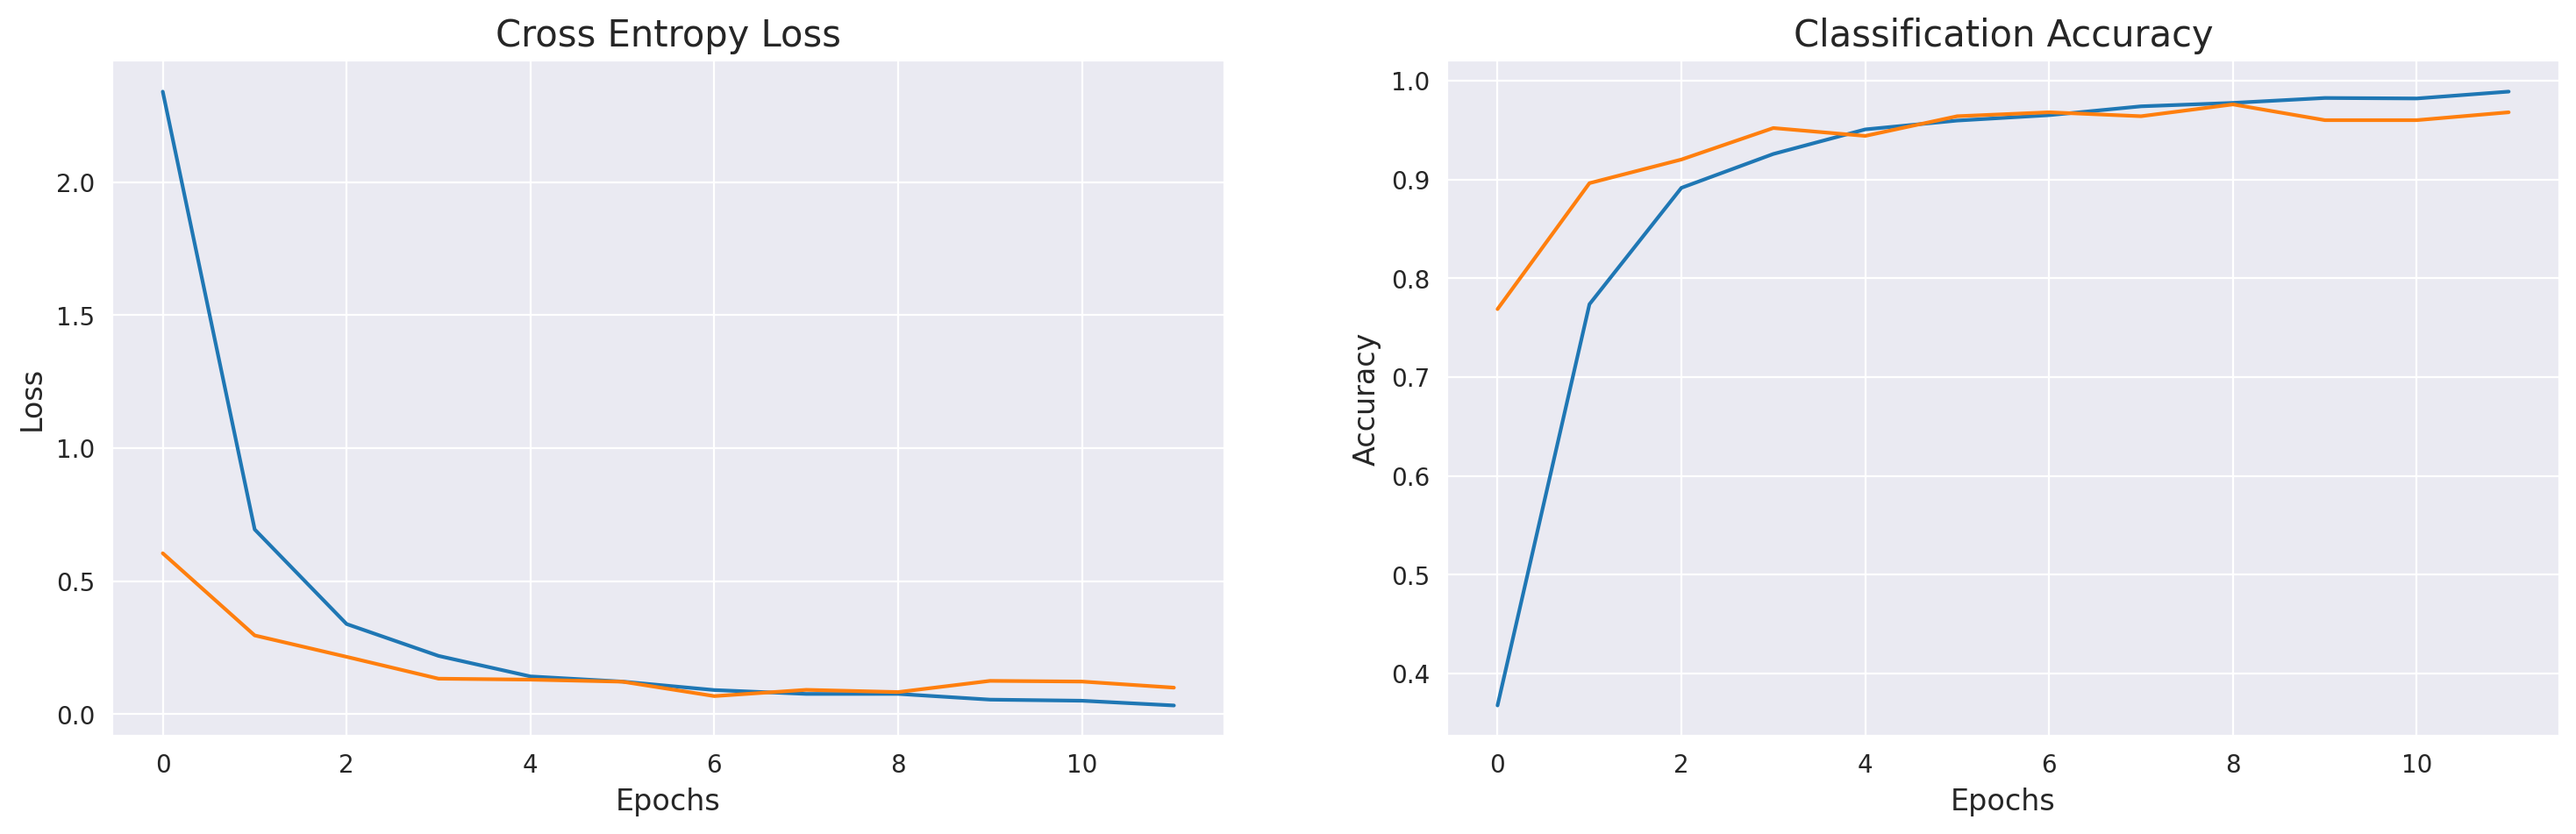

In [ ]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(asl_class.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

<a id='17'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Prediction </h2> </div>

Now, we will predict the labels for the test data which will give us clear idea about the accuracy of the model.


In [ ]:
# Extrair y_true do test_data
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)

# Caso o label_mode='categorical', converta de one-hot para índice
y_true = np.argmax(y_true, axis=1)

# Predição
result = model.predict(test_data, verbose=0)
y_pred = np.argmax(result, axis=1)

# Avaliação
loss, acc = model.evaluate(test_data, verbose=0)
print('The accuracy of the model for testing data is:', acc * 100)
print('The Loss of the model for testing data is:', loss)

The accuracy of the model for testing data is: 93.2539701461792
The Loss of the model for testing data is: 0.3482499420642853


The count of correctly and incorrectly classified images.

In [ ]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 235
Incorrect predicted classes: 17


Classification report

In [ ]:
print(classification_report(y_true, y_pred,target_names= categories.values()))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.88      1.00      0.93         7
           2       0.86      0.86      0.86         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      0.71      0.83         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
           a       1.00      1.00      1.00         7
           b       1.00      0.86      0.92         7
           c       1.00      1.00      1.00         7
           d       0.88      1.00      0.93         7
           e       1.00      1.00      1.00         7
           f       1.00      1.00      1.00         7
           g       1.00      0.86      0.92         7
           h       1.00    

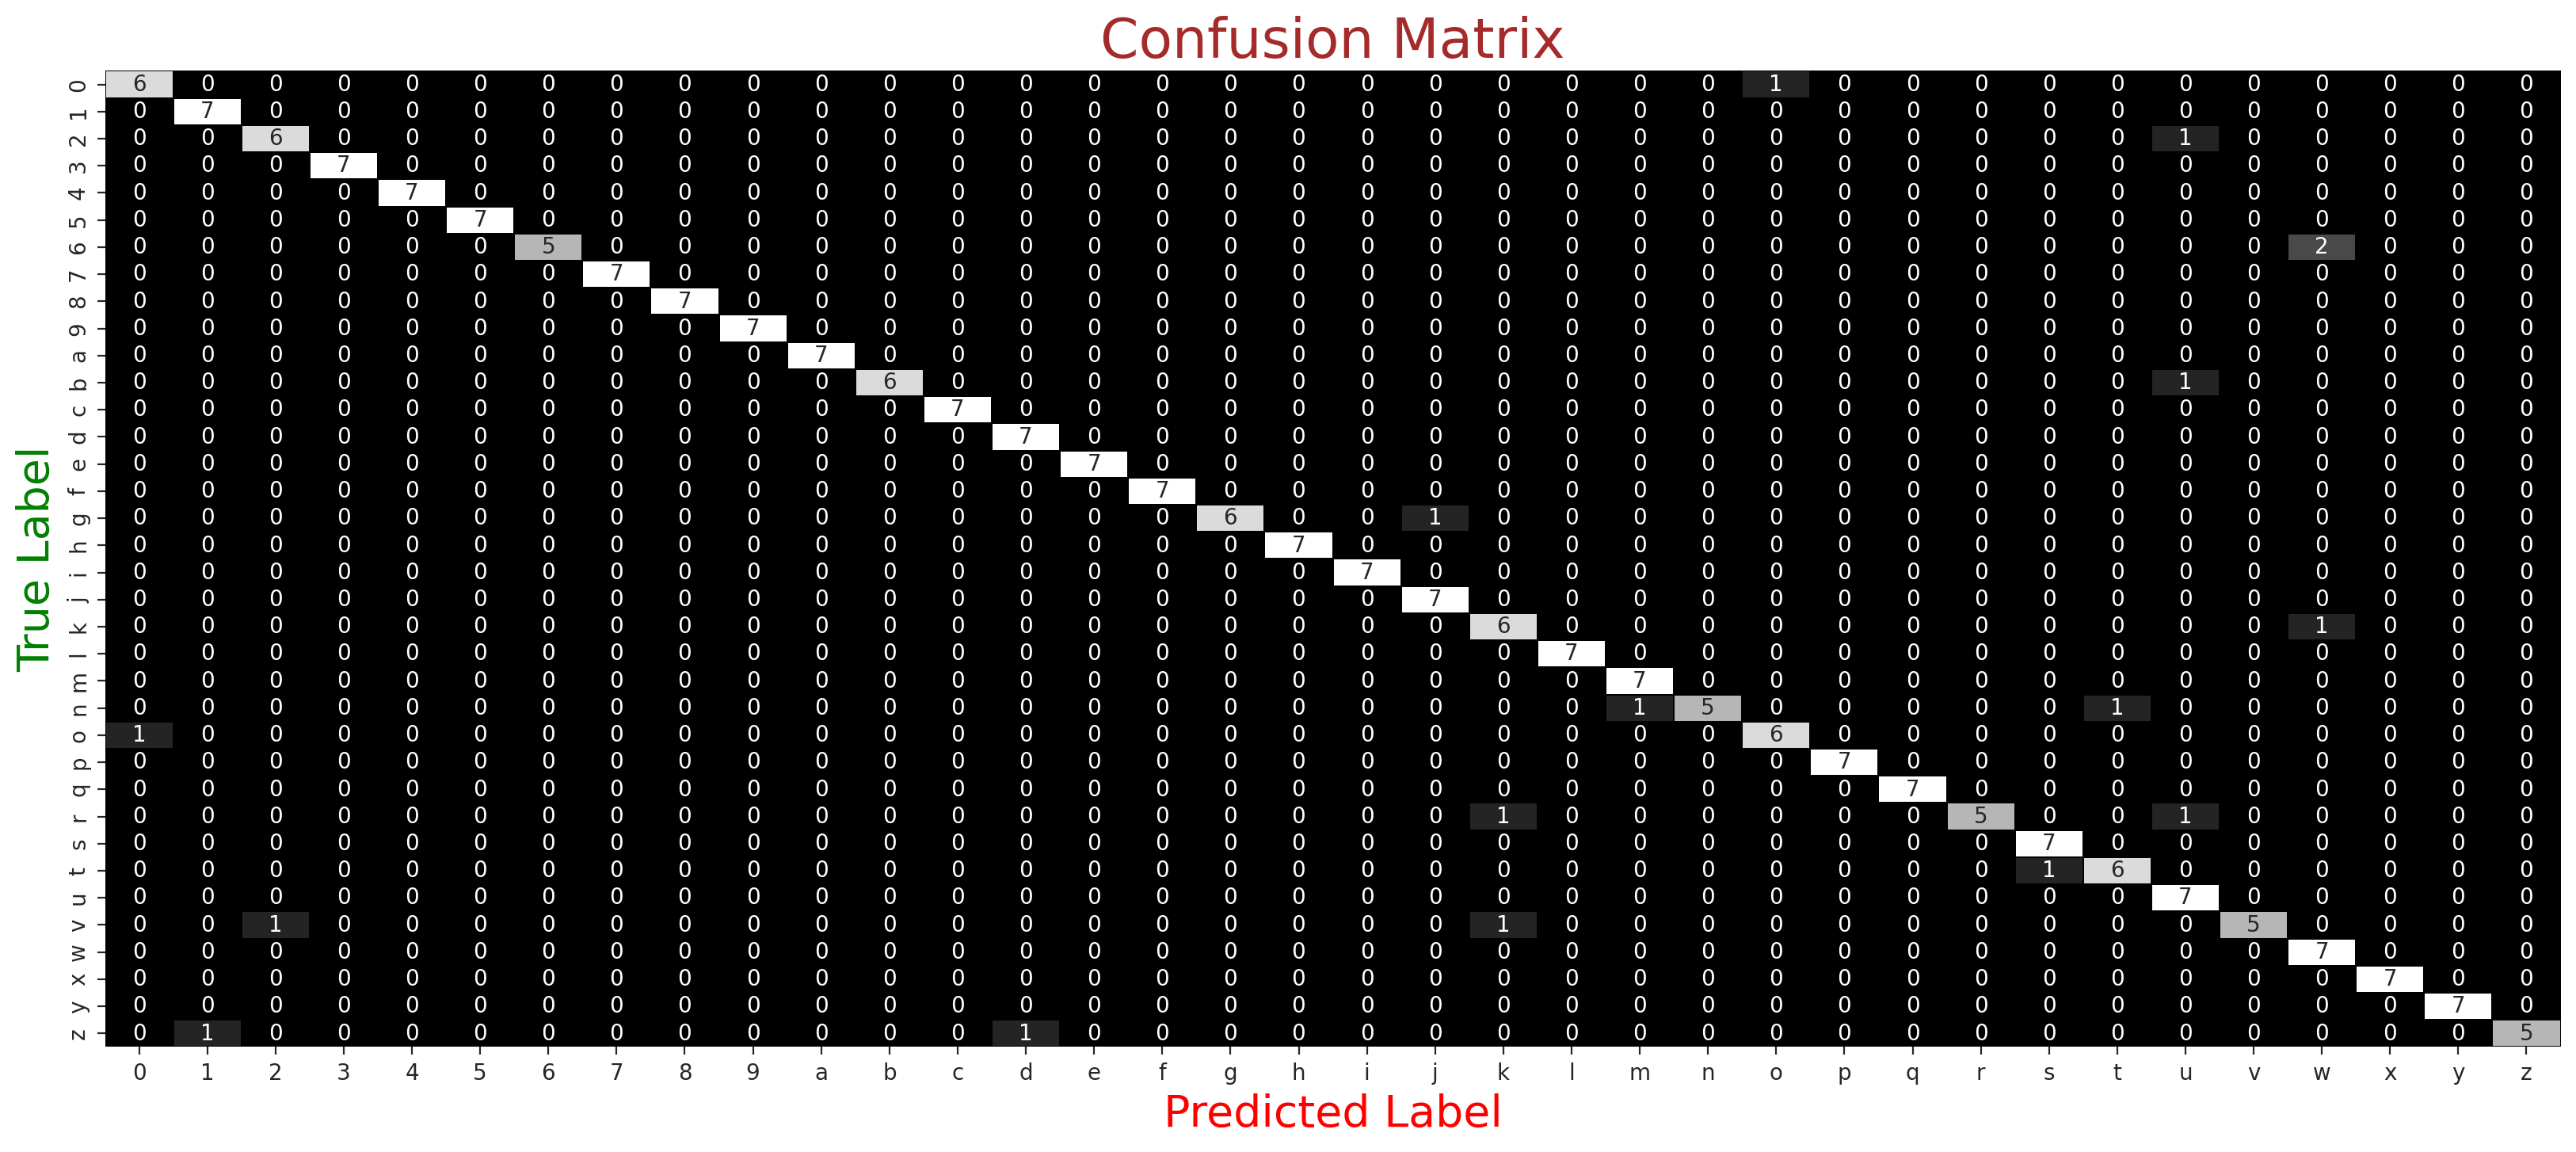

In [ ]:
 sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred)

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.1, cmap = "gist_yarg_r",
            linecolor="black", fmt='.0f', ax=ax,
            cbar=False, xticklabels=categories.values(),
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()

<a id='18'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Conclusion </h2> </div>

We successfully built a deep neural network model by implementing Convolutional Neural Network (CNN) to classify hand sign images with very high accuracy 97.00 %.

I have tried increasing the image size which didn't result in increase the testing accuracy.

The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.

The hand sign Classification model demonstrates the successful implementation of a Convolutional Neural Network for image classification tasks.

By accurately distinguishing between images of hand signs, this project showcases the potential of deep learning algorithms in solving real-world problems involving image analysis. Through this project, we aim to inspire further exploration of CNNs and their applications in various domains,

<h4 style="text-align:center;color:red">If you found value in the content and had a positive experience, I would greatly appreciate it if you could consider giving it an upvote ⬆️.</h4>

> <h4 style="color:blue;text-align:Center"> Highly appreciate your questions or feedback related to this notebook. </h4>